### 1. Calculate water percentage in the footprint
### 2. Add tgauge station information, e.g., time, location, sea level and distance to fp.


In [1]:
import sys
sys.path.append("../utils")
import xarray as xr
import numpy as np
import os
from tiff_io import readTiff
from imgShow import imgShow
import matplotlib.pyplot as plt
from tgauge_time_search import tgauge_time_search
from fp_water import fp_mask, fp_wat_cal, fp_show
from fp_water import get_fp_angle, get_fps_wat
from osgeo import gdal
from get_filesPath import get_filesPath
from tgauge_fp_dist import tgauge_fp_dist
from coor_convert import geo2imagexy
import torch


In [2]:
root_dir = os.path.dirname(os.getcwd())
path_rsimg_wat = root_dir+'/test_data/rs_image/greatbay_l8_img_wat_sel.tif'
path_rsimg = root_dir+'/test_data/rs_image/greatbay_l8_img.tif'
dir_s3l2 = root_dir+'/test_data/s3a-relative-orbit-260&309'
path_tgauge = root_dir+'/test_data/tgauge_data/hk_tide_gauge.nc'
path_dl_model = dir_model_save = root_dir + '/results/cnn_1d_improve'


In [3]:
## data prepare
# 1. get files path
files_path = get_filesPath(base=dir_s3l2, key_words='enhanced_measurement_subs.nc')
files_path = sorted(files_path)
print('s3l2 files number:', len(files_path))
# 2. read water mask, l8 image and img_gdal information
l8_img, im_geotrans, im_proj, im_row, im_col, im_bands = readTiff(path_rsimg)
l8_img_wat,_,_,_,_,_ = readTiff(path_rsimg_wat)
img_gdal = gdal.Open(path_rsimg)
tgauge_data = xr.open_dataset(path_tgauge)
## print(files_path)
# 3. load the pre-trained deep learning model
model = torch.load(path_dl_model)
# model


s3l2 files number: 50


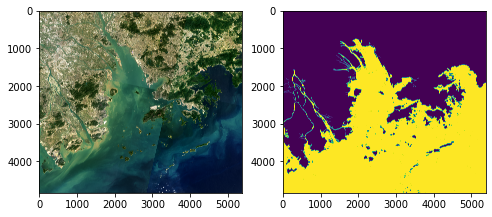

In [4]:
## visualize the remote sensing image and water map
plt.figure(figsize=(8,4))
plt.subplot(121)
imgShow(l8_img)
plt.subplot(122)
plt.imshow(l8_img_wat)


In [5]:
# ind_dis_near = np.nanargmin(s3_l2['dis_fp_tgauge'])


_20_ku with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:46: SerializationWarning: saving variable lat_20_c with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:46: SerializationWarning: saving variable lon_20_c with floating point data as an integer dtype without any _FillValue to use for NaNs
/Users/luo/OneDrive/SWOT/Code-algorithms/radar-altimetry-toolbox/test_data/s3a-relative-orbit-260&309/S3A_SR_2_WAT____20200524T134003_20200524T142755_20200619T060829_2872_058_309______MAR_O_NT_004.SEN3/enhanced_measurement_subs.nc
ipykernel_launcher:46: SerializationWarning: saving variable lat_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:46: SerializationWarning: saving variable lon_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:46: SerializationWarning: saving variable lat_2

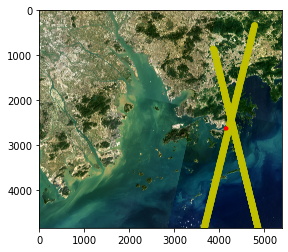

In [7]:
imgShow(l8_img)
for path_s3l2 in files_path:
    print(path_s3l2)
    s3_l2 = xr.open_dataset(path_s3l2)

    ### 1. calculate water percentate in the footprint
    col_fps, row_fps = geo2imagexy(lon=s3_l2['lon_20_ku'], lat=s3_l2['lat_20_ku'],img_gdal=img_gdal)
    col_tgauge, row_tgauge = geo2imagexy(lon=tgauge_data['lon'], lat=tgauge_data['lat'], img_gdal=img_gdal)
    plt.plot(col_tgauge, row_tgauge, 'r.')    # visualize the tgauge station   
    plt.plot(col_fps, row_fps, 'y.')    # visualize the footprint
    angle_e = get_fp_angle(row_fps=row_fps,col_fps=col_fps)
    fp_wat_per = get_fps_wat(wat_map=l8_img_wat, angle_e=angle_e, row_fps=row_fps, col_fps=col_fps)
    s3_l2["fp_wat_per"] = (['time_20_ku'], fp_wat_per)
    s3_l2["fp_wat_per"].attrs['name'] = 'surface water percentage in the footprint'

    ### 2. add tgauge station information, e.g., time, location, sea level and distance to fp.
    ind_start, ind_end, tgauge_time = tgauge_time_search(tgauge_data=tgauge_data, s3_l2=s3_l2)
    dis_fp_tgauge = tgauge_fp_dist(s3_l2=s3_l2,tgauge_data=tgauge_data)  
    ## location
    s3_l2.coords['lon_tgauge'] = (['num_tgauge'], tgauge_data['lon'].values)
    s3_l2.coords['lat_tgauge'] = (['num_tgauge'], tgauge_data['lat'].values)
    ## time
    s3_l2.coords['time_tgauge']= ('time_tgauge', tgauge_time.values)
    s3_l2.coords['time_tgauge'].attrs['name'] = 'UTC: time corresponding to altimetry data time'
    ## sea level
    s3_l2['ssha_tgauge'] = ('time_tgauge', tgauge_data['sea_level'][0][ind_start:ind_end+1].values/1000)
    s3_l2['ssha_tgauge'].attrs['name'] = 'sea level from tgauge data'
    s3_l2['ssha_tgauge'].attrs['unit'] = 'meter'
    ## distance to footprint
    s3_l2['dis_fp_tgauge'] = ('time_20_ku', dis_fp_tgauge)
    s3_l2['dis_fp_tgauge'].attrs['name'] = 'distance between the footprint and tide gauge station'
    s3_l2['dis_fp_tgauge'].attrs['unit'] = 'kilometer'

    ### 3. add waveform class derived by deep learning model
    wf = s3_l2['waveform_20_ku'].values
    wf_nor = [wf[i]/np.max(wf[i]) for i in range(wf.shape[0])] # waveform normalization
    wf_nor = torch.unsqueeze(torch.Tensor(wf_nor), 1)
    pred = model(wf_nor)
    _, pred = torch.max(pred, 1)
    s3_l2["wf_cls"] = (['time_20_ku'], pred.numpy())
    s3_l2["wf_cls"].attrs['name'] = 'waveform class derived by deep learning model, 1 and 0 represent ocean-like waveform and noisy waveform, respectively.'
    ### writh to new .nc file
    dir_file = os.path.split(path_s3l2)[0]
    name_file = os.path.split(path_s3l2)[1].split('.')[0]
    path_s3l2_new = os.path.join(dir_file, name_file+'_preproc.nc')
    s3_l2.to_netcdf(path=path_s3l2_new)
